In [2]:
import numpy as np
from math import *
import random
import itertools
from scipy.optimize import root
from scipy import stats
from scipy import special
import copy
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import pickle
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec

### Find coexistence

There will be numerical experiments on "plates" with 90 mMeqC (carbon) supplied, at a 12.5% glucose - 87.5% xylose mix, with mutual invasion results.

In [6]:
strains = pd.read_excel('barthe_strains.xlsx')
strains

,strains,BL21(DE3),BW25113,BW30270,SE15,Nissle 1917,MG1655,1404,LF82,E22,CA244,M1/5,S5Vir,E2348/69,Mean,StdDev
0,g_glu [1/h],0.688469,0.726543,0.887784,0.941143,0.812755,0.620659,0.917831,0.914251,0.748231,0.642962,0.885961,0.947523,0.682365,0.801268,0.116036
1,g_xyl [1/h],0.216049,0.660447,0.632216,0.678226,0.642158,0.539396,0.860129,0.868032,0.627074,0.677942,0.335297,0.888976,0.577474,0.631032,0.186374
2,Y_glu [OD600/mMeqC],0.011348,0.011459,0.011059,0.011780,0.010687,0.008255,0.012759,0.011505,0.010817,0.006884,0.011696,0.011391,0.009750,0.010722,0.001522
3,Y_xyl [OD600/mMeqC],0.010636,0.011121,0.009733,0.012122,0.010871,0.008783,0.011030,0.011656,0.010022,0.007332,0.012504,0.010520,0.009834,0.010474,0.001331
4,tau_diauxie [h],0.000000,0.398551,0.498551,0.434783,0.811594,0.375362,0.360870,0.797102,0.473913,0.600000,0.873913,0.847826,0.740580,0.554850,0.244169
5,tau_regrowth [h],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dynamics

In [5]:
def dilute_check(system, growth_rate_list, lagtimes_list, ignore_this_run = False, ReturnInvasionChance = True):
    # t_points is the end of each nutrient's depletion, as well as 0 and T_dilution(period).
    t_points = []
    # c_points is the bug densities of each t point.
    c_points = []
    # r_points is the available nutrients at each t point.
    r_points = []
    #conc_points is the concentration of each nutrient.
    conc_points = []
    # inv_points is the measure of conflict or invasibility at each t point. 
    inv_points = []
    t_switch = 0
    t_points.append(t_switch)
    survivors, concent, pref_list, growth = output(system)
    c_points.append(concent)
    conc_points.append([i for i in system['res_concentration']])
    a = [i for i in system['res_available']]
    r_points.append(a)
    lag_flag = [1 for i in range(Nb)]
    lag_begins = [0 for i in range(Nb)]
    #list of resource in use for each consumer
    use = [0 for i in range(Nb)]
    while t_switch < T_dilute:
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][preference_list[i//Size][use[i]]] < 1 and use[i] < Nr - 1: # when there's no current resource left
                use[i] = use[i] + 1 # goto next resource
                lag_flag[i] = 1 # start the lag
                lag_begins[i] = t_switch # and mark the starting point. Notice: lags do lap with each other.
            if system['bug_available'][i] > 0:
                consumer[preference_list[i//Size][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i] if lag_flag[j] == 0])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        for i in range(Nb):
            if lag_flag[i]*system['bug_available'][i] == 1:
                t_i = lag_begins[i] + float(lagtimes_list[i][use[i]]) - t_switch
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        ResInUse = sum([int(i!=[]) for i in consumer])
        ResAvailable = sum(system['res_available'])
        if(ResAvailable!=0):
            inv_points.append(1-ResInUse/ResAvailable)
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][preference_list[i//Size][use[i]]] > 0 and lag_flag[i] == 0:
                temp_bug_density[i] = system['bug_density'][i]*exp(growth_rate_list[i][preference_list[i//Size][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i] if lag_flag[j] == 0])
                if system['res_concentration'][i] < c_threshold:
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
        t_points.append(t_switch)
        survivors, concent, pref_list, growth = output(system)
        c_points.append(concent)
        a = [i for i in system['res_available']]
        r_points.append(a)
        conc_points.append([i for i in system['res_concentration']])
        for i in range(Nb):
            if lag_flag[i] == 1 and lag_begins[i] + float(lagtimes_list[i][use[i]]) == t_dep + t_switch:
                lag_flag[i] = 0 
                lag_begins[i] = 0 # there might be multiple bugs doing their lags together, so need to screen everything again
    if(ignore_this_run == False):
        global details
        details['t_info'].append(t_points)
        details['bug_info'].append((survivors, c_points))
        details['res_left'].append(r_points)
        if('res_concent' in details):
            details['res_concent'].append(conc_points)
        if('round_idx' in details.keys()):
            details['round_idx'].append(details['round_idx'][-1]+1)
    return system, t_points, c_points, r_points
# you can modify the fluctuating environment here.
def move_to_new(system, fluc = []):
    global Res
    global details
    global movestep
    movestep += 1
    baseline = [Nr * i / sum(Res) for i in Res]
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + baseline[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    Res = baseline
    details['res_begin'].append(baseline)
    return system

def invade(system, bug, growth_rate_list, lagtime_list, invlist= []):
    global details
    # (starting from a new flask)
    # then add invasive species
    system1 = copy.deepcopy(system)
    # then dilute till steady
    system1, t_points, c_points, r_points = dilute_check(system1, growth_rate_list, lagtime_list, ignore_this_run=True)
    accum = 0
    if(sum(system['bug_available']) != 0):
        t_begin = t_points[0]
        nut = 0
        for idx in range(len(t_points)):
            if(idx == len(t_points)-1 or r_points[idx][preference_list[bug//Size][nut]] == 0):
                t_end = t_points[idx]
                t_slot = t_end - t_begin
                t_slot -= lagtime_list[bug][preference_list[bug//Size][nut]]
                if(t_slot>0): 
                    accum += t_slot*growth_rate_list[bug][preference_list[bug//Size][nut]]
                while(nut < Nr and r_points[idx][preference_list[bug//Size][nut]] == 0): nut += 1
                t_begin = t_end
                if(nut==Nr):break
    if accum > log(1/D)*1.001 or sum(system['bug_available']) == 0:
        system['bug_available'][bug] = 1
        system['bug_density'][bug] = b0
        idx=0
        eqm = 0
        while(len(output(system)[0])>Nr or idx < dilute_to_steady or eqm == 0):
            idx=idx+1
            system, t_points, c_points, r_points = dilute_check(system, growth_rate_list, lagtime_list)
            if sum(system['bug_available']) == 0:
                details = {'res_begin':[], 't_info':[], 'res_left':[], 'bug_info':[], 'round_idx':[0]}
                system = {'res_available': np.heaviside(Res, 0), 'res_concentration': [i for i in Res], 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]}
                break
            # move to a new flask
            system = move_to_new(system, fluc=[])
            if(len(details['bug_info']) > 2):
                if(len(details['bug_info'][-1][0]) == len(details['bug_info'][-2][0])):
                    if max([abs(details['bug_info'][-1][1][1][j]-details['bug_info'][-2][1][1][j])/details['bug_info'][-2][1][1][j] for j in range(len(details['bug_info'][-2][1][1]))]) < 1e-4:
                        eqm = 1
        system, t_points, c_points, r_points = dilute_check(system, growth_rate_list, lagtime_list)
        system = move_to_new(system, fluc=[])
        ext_list = [i for i in invlist if system['bug_available'][i] == 0]
        return system, ext_list
    else:
        ext_list = [i for i in invlist if system['bug_available'][i] == 0]
        if('round_idx' in details.keys()):
            details['round_idx'][-1] += T_dilute
        return system, ext_list

def round_robin_invade(system, ext_list, growth_rate_list, lagtime_list):
    for bug in ext_list:
        system, new_ext_list = invade(system, bug, growth_rate_list, lagtime_list, ext_list)
    return system, new_ext_list

def output(system):
    survivors = [i for i, v in enumerate(system['bug_available']) if v != 0]
    pref_list = []
    concent = []
    growth = []
    for i in survivors:
        pref_list.append(preference_list[i//Size])
        concent.append(system['bug_density'][i])
        growth.append(growth_rate_list[i])
    return survivors, concent, pref_list, growth

### Run the pairwise invasion experiments

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import *

Nr=2
Size=1
Nb=2
T_dilute=24
dilute_to_steady=10
b0=1e-6
b_threshold = 1e-6 # extinction density
c_threshold = 1e-9 # concentration threshold
Res = [.125, .875] # here the unit of carbon res is 90mMeqC, and there will be corresponding change in Yields
preference_list = [(0, 1), (0, 1)]

In [19]:
def coex(strain1, strain2, Dilution):
    global D, growth_rate_list, yields_list, lagtimes_list, movestep, details, system
    D=Dilution
    growth_rate_list=[[strains[strain1][0], strains[strain1][1]], [strains[strain2][0], strains[strain2][1]]]
    yields_list=np.array([[strains[strain1][2], strains[strain1][3]], [strains[strain2][2], strains[strain2][3]]])*90
    lagtimes_list=[[regrowth_lags[list(strains.columns).index(strain1)-1], diauxic_lags[list(strains.columns).index(strain1)-1]], [regrowth_lags[list(strains.columns).index(strain2)-1], diauxic_lags[list(strains.columns).index(strain2)-1]]]
#     lagtimes_list = [[0, 0], [0, 0]]
#     print(lagtimes_list)
    movestep=0
    details = {'res_begin':[], 't_info':[], 'res_left':[], 'bug_info':[], 'round_idx':[0]}
    system = {'res_available': np.heaviside(Res, 0), 'res_concentration': [i for i in Res], 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]}
    system, _ = invade(system, 0, growth_rate_list, lagtimes_list, [])
    system, _ = invade(system, 1, growth_rate_list, lagtimes_list, [])
    return(output(system))

### With 100 sets of lag values, do the invasion simulations

0
1
2
3
4
5
6
7
8
9
10
11
12


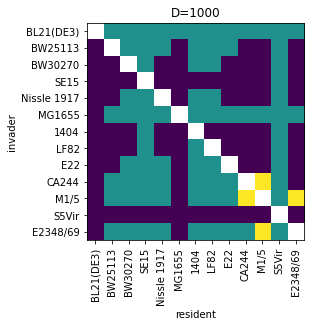

0
1
2
3
4
5
6
7
8
9
10
11
12


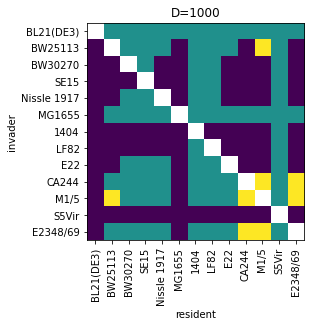

0
1
2
3
4
5
6
7
8
9
10
11
12


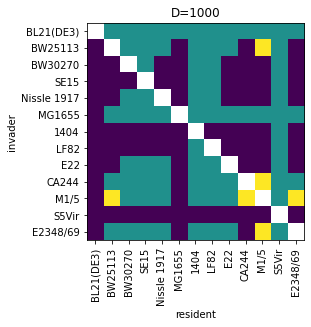

0
1
2
3
4
5
6
7
8
9
10
11
12


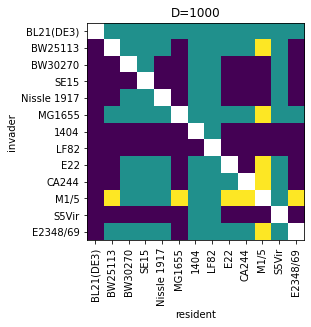

0
1
2
3
4
5
6
7
8
9
10
11
12


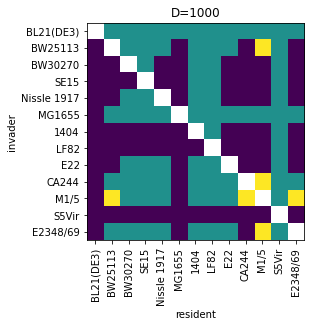

0
1
2
3
4
5
6
7
8
9
10
11
12


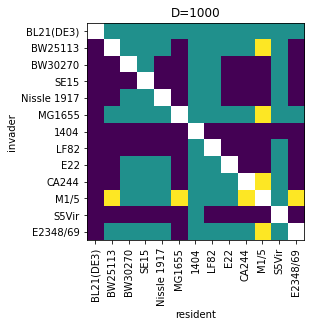

0
1
2
3
4
5
6
7
8
9
10
11
12


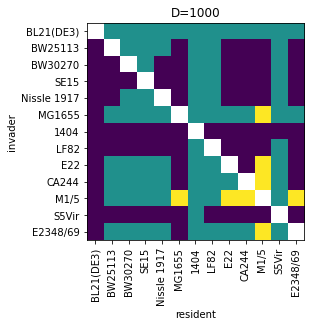

0
1
2
3
4
5
6
7
8
9
10
11
12


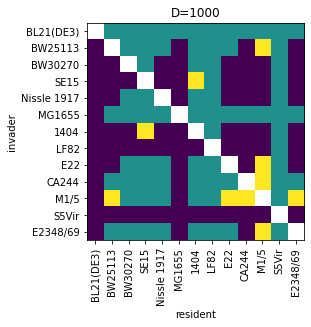

0
1
2
3
4
5
6
7
8
9
10
11
12


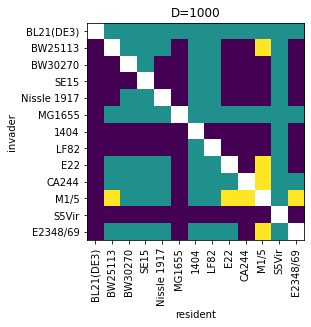

0
1
2
3
4
5
6
7
8
9
10
11
12


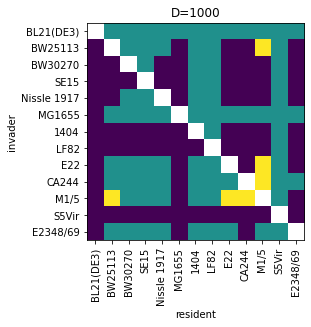

0
1
2
3
4
5
6
7
8
9
10
11
12


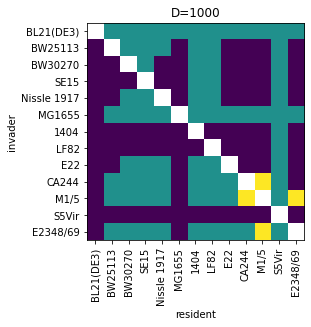

0
1
2
3
4
5
6
7
8
9
10
11
12


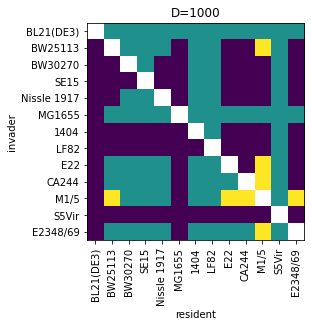

0
1
2
3
4
5
6
7
8
9
10
11
12


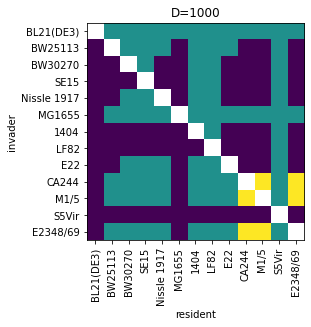

0
1
2
3
4
5
6
7
8
9
10
11
12


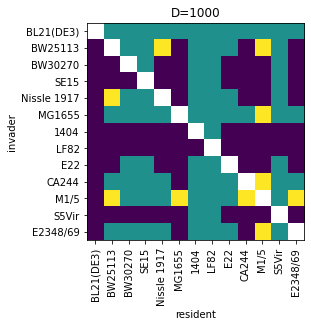

0
1
2
3
4
5
6
7
8
9
10
11
12


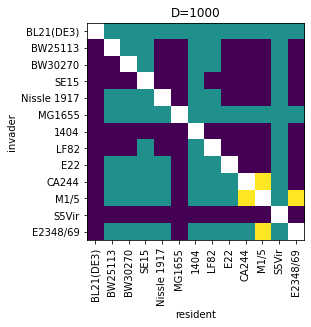

0
1
2
3
4
5
6
7
8
9
10
11
12


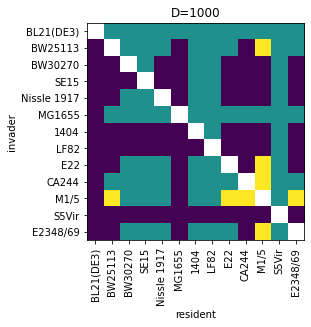

0
1
2
3
4
5
6
7
8
9
10
11
12


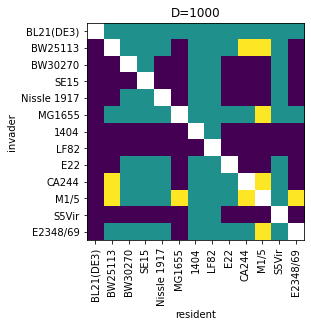

0
1
2
3
4
5
6
7
8
9
10
11
12


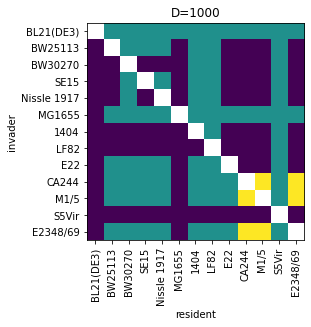

0
1
2
3
4
5
6
7
8
9
10
11
12


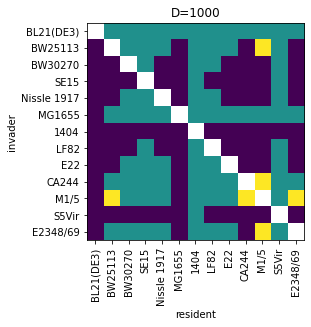

0
1
2
3
4
5
6
7
8
9
10
11
12


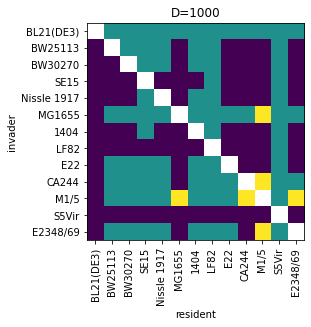

0
1
2
3
4
5
6
7
8
9
10
11
12


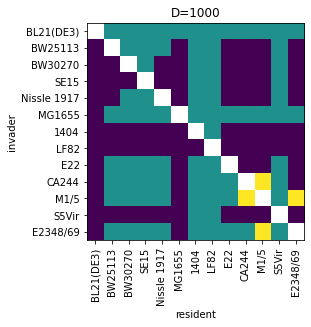

0
1
2
3
4
5
6
7
8
9
10
11
12


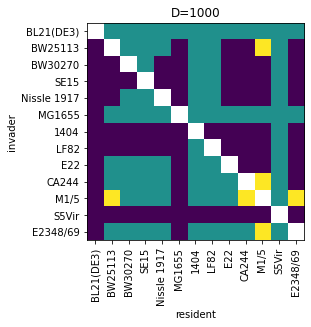

0
1
2
3
4
5
6
7
8
9
10
11
12


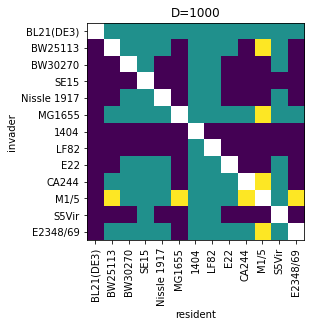

0
1
2
3
4
5
6
7
8
9
10
11
12


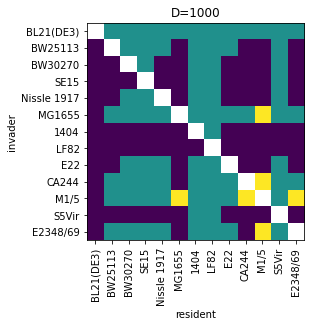

0
1
2
3
4
5
6
7
8
9
10
11
12


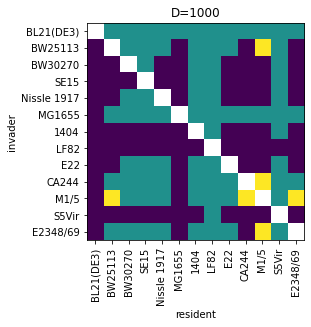

0
1
2
3
4
5
6
7
8
9
10
11
12


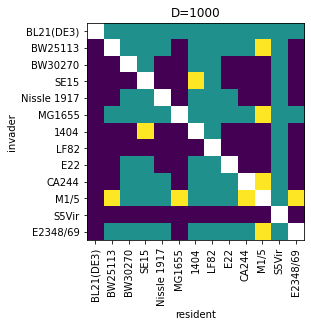

0
1
2
3
4
5
6
7
8
9
10
11
12


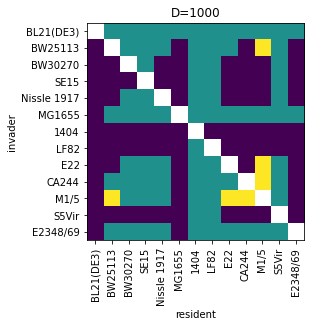

0
1
2
3
4
5
6
7
8
9
10
11
12


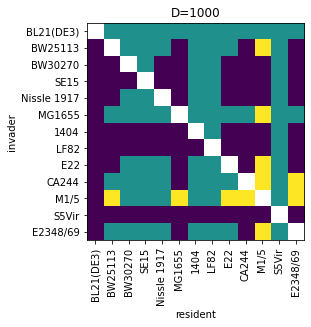

0
1
2
3
4
5
6
7
8
9
10
11
12


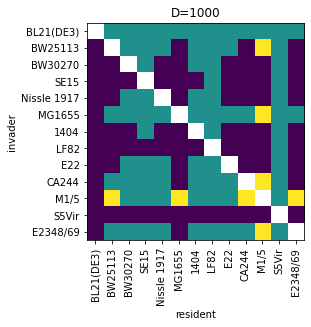

0
1
2
3
4
5
6
7
8
9
10
11
12


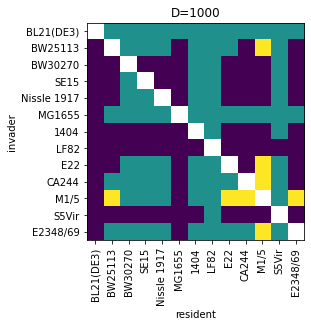

0
1
2
3
4
5
6
7
8
9
10
11
12


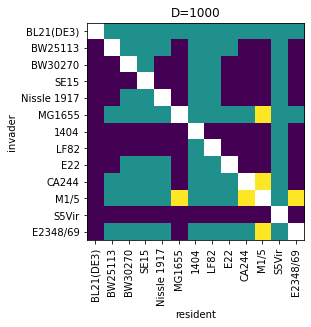

0
1
2
3
4
5
6
7
8
9
10
11
12


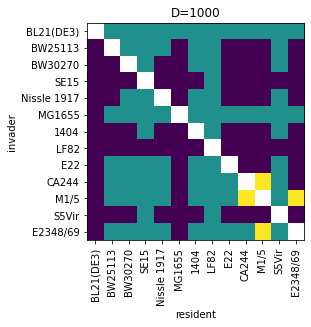

0
1
2
3
4
5
6
7
8
9
10
11
12


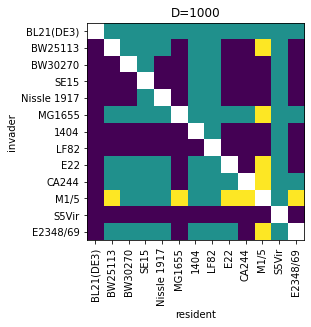

0
1
2
3
4
5
6
7
8
9
10
11
12


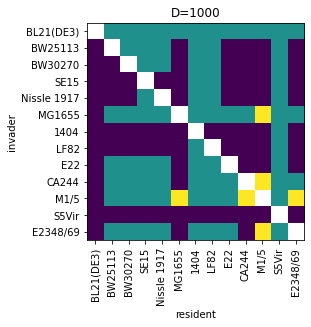

0
1
2
3
4
5
6
7
8
9
10
11
12


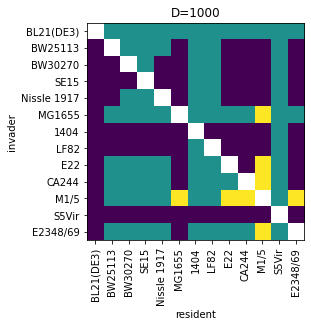

0
1
2
3
4
5
6
7
8
9
10
11
12


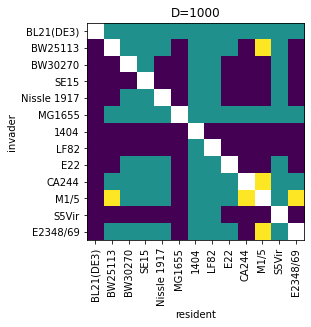

0
1
2
3
4
5
6
7
8
9
10
11
12


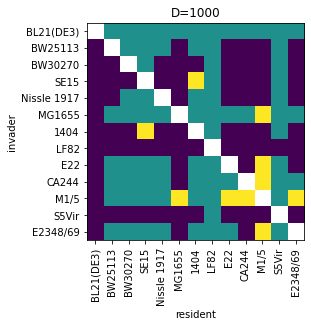

0
1
2
3
4
5
6
7
8
9
10
11
12


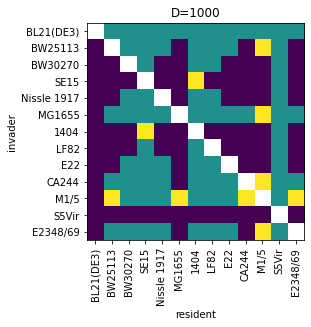

0
1
2
3
4
5
6
7
8
9
10
11
12


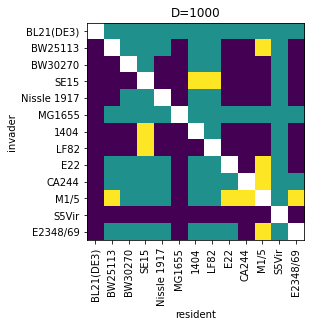

0
1
2
3
4
5
6
7
8
9
10
11
12


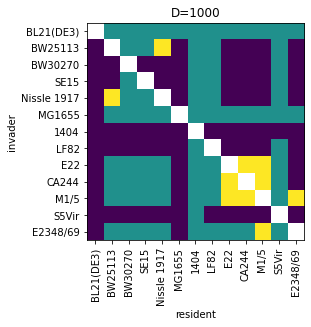

0
1
2
3
4
5
6
7
8
9
10
11
12


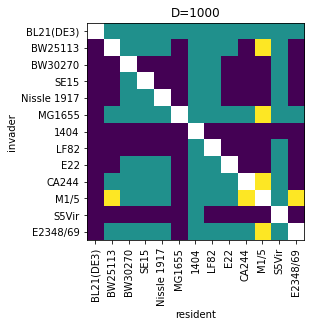

0
1
2
3
4
5
6
7
8
9
10
11
12


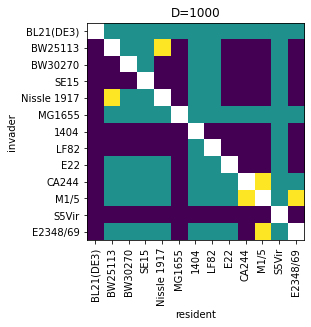

0
1
2
3
4
5
6
7
8
9
10
11
12


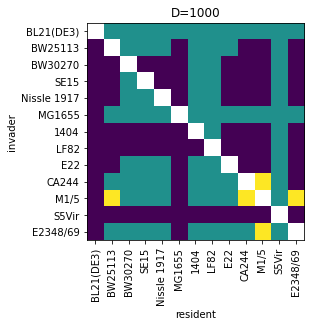

0
1
2
3
4
5
6
7
8
9
10
11
12


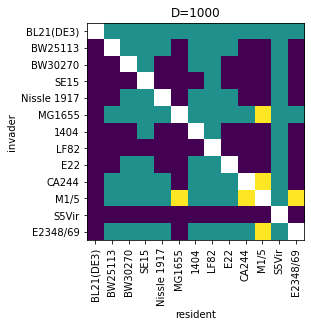

0
1
2
3
4
5
6
7
8
9
10
11
12


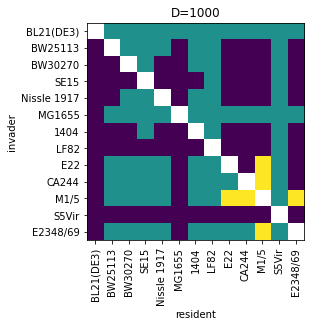

0
1
2
3
4
5
6
7
8
9
10
11
12


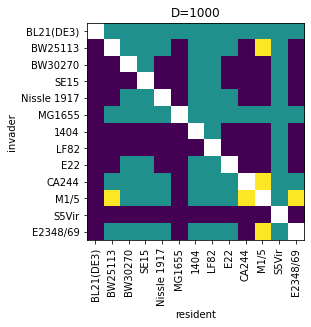

0
1
2
3
4
5
6
7
8
9
10
11
12


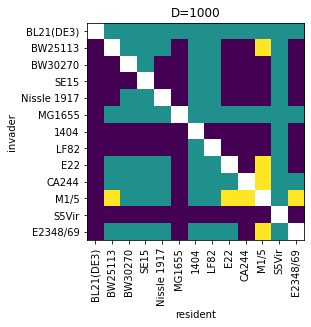

0
1
2
3
4
5
6
7
8
9
10
11
12


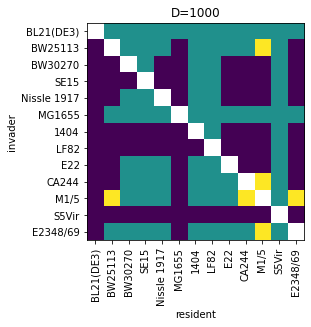

0
1
2
3
4
5
6
7
8
9
10
11
12


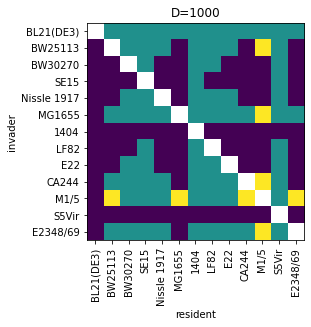

0
1
2
3
4
5
6
7
8
9
10
11
12


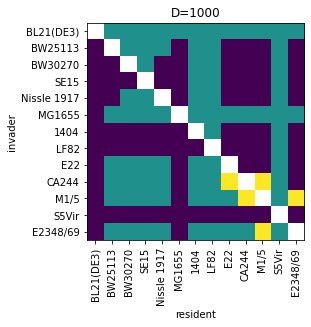

0
1
2
3
4
5
6
7
8
9
10
11
12


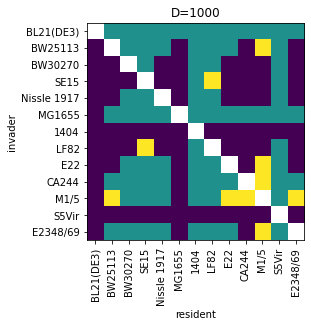

0
1
2
3
4
5
6
7
8
9
10
11
12


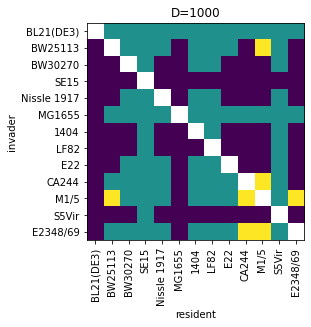

0
1
2
3
4
5
6
7
8
9
10
11
12


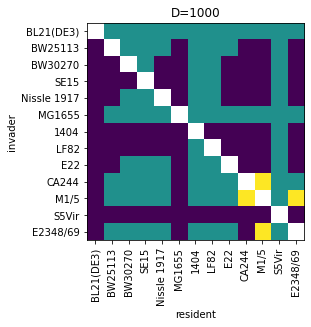

0
1
2
3
4
5
6
7
8
9
10
11
12


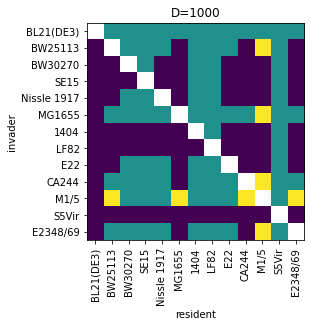

0
1
2
3
4
5
6
7
8
9
10
11
12


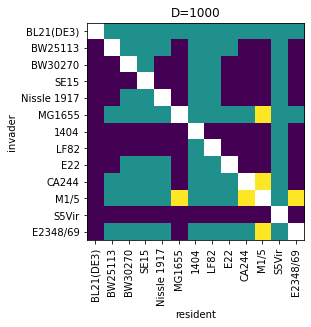

0
1
2
3
4
5
6
7
8
9
10
11
12


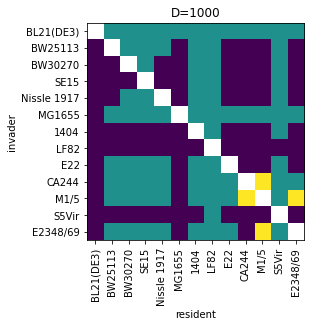

0
1
2
3
4
5
6
7
8
9
10
11
12


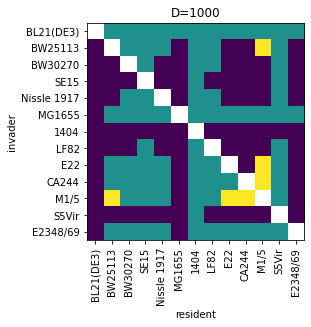

0
1
2
3
4
5
6
7
8
9
10
11
12


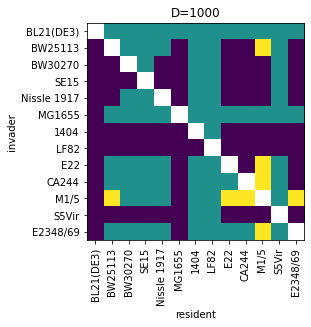

0
1
2
3
4
5
6
7
8
9
10
11
12


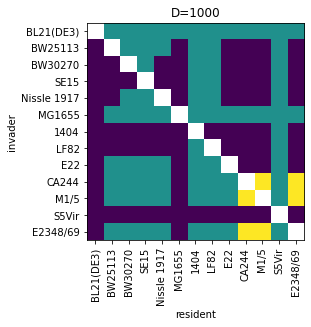

0
1
2
3
4
5
6
7
8
9
10
11
12


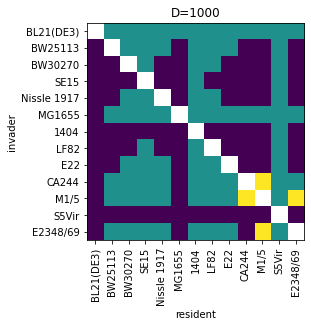

0
1
2
3
4
5
6
7
8
9
10
11
12


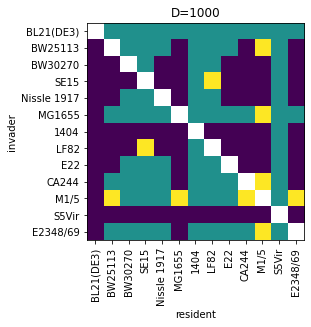

0
1
2
3
4
5
6
7
8
9
10
11
12


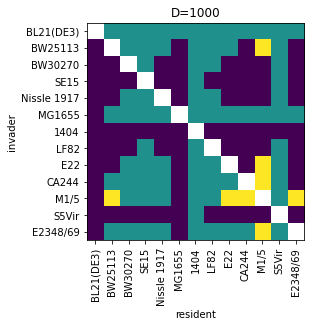

0
1
2
3
4
5
6
7
8
9
10
11
12


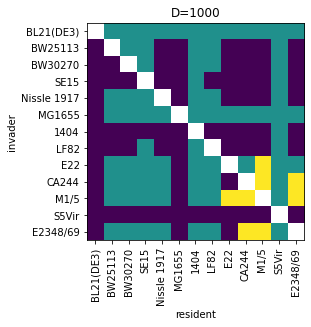

0
1
2
3
4
5
6
7
8
9
10
11
12


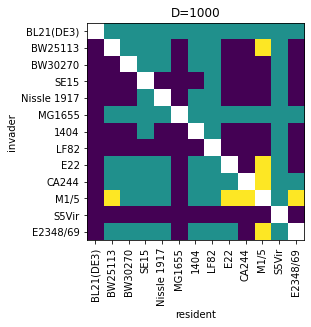

0
1
2
3
4
5
6
7
8
9
10
11
12


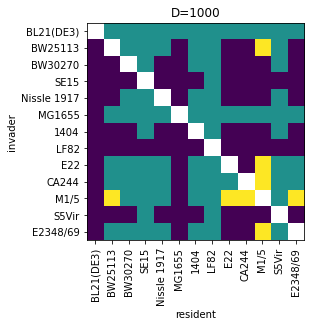

0
1
2
3
4
5
6
7
8
9
10
11
12


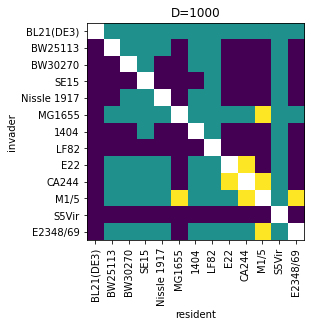

0
1
2
3
4
5
6
7
8
9
10
11
12


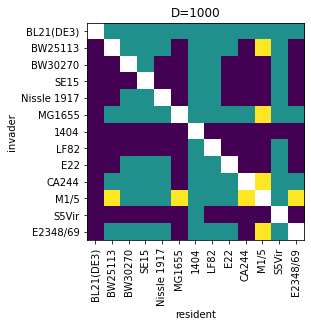

0
1
2
3
4
5
6
7
8
9
10
11
12


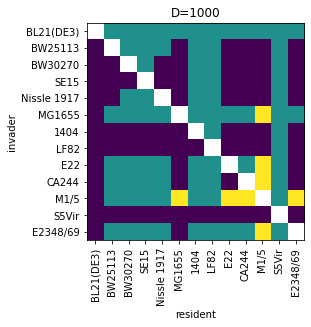

0
1
2
3
4
5
6
7
8
9
10
11
12


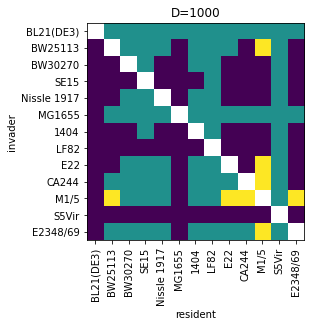

0
1
2
3
4
5
6
7
8
9
10
11
12


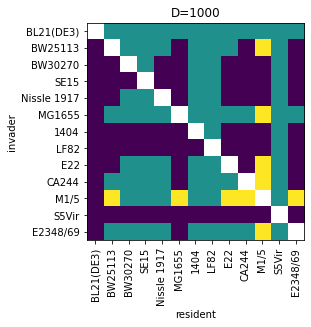

0
1
2
3
4
5
6
7
8
9
10
11
12


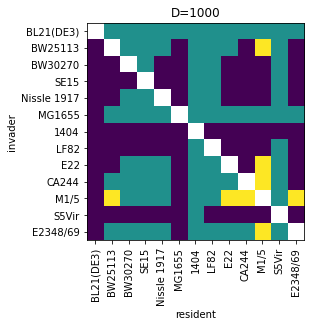

0
1
2
3
4
5
6
7
8
9
10
11
12


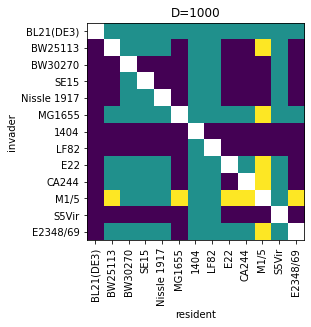

0
1
2
3
4
5
6
7
8
9
10
11
12


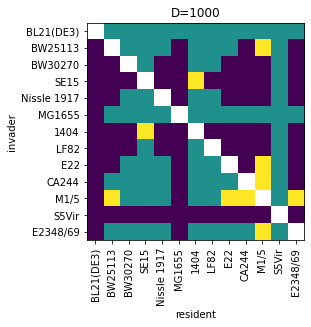

0
1
2
3
4
5
6
7
8
9
10
11
12


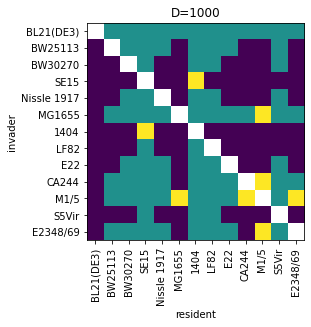

0
1
2
3
4
5
6
7
8
9
10
11
12


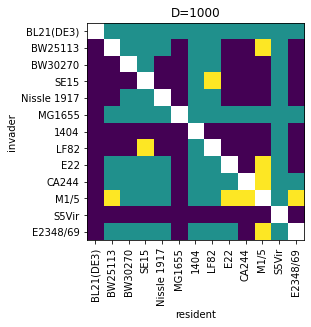

0
1
2
3
4
5
6
7
8
9
10
11
12


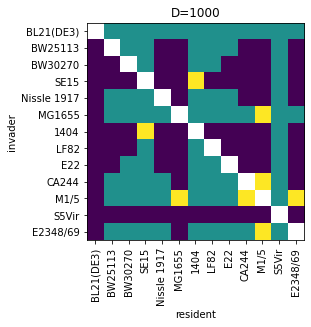

0
1
2
3
4
5
6
7
8
9
10
11
12


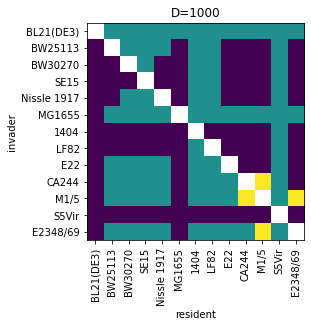

0
1
2
3
4
5
6
7
8
9
10
11
12


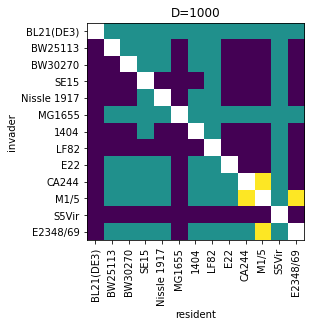

0
1
2
3
4
5
6
7
8
9
10
11
12


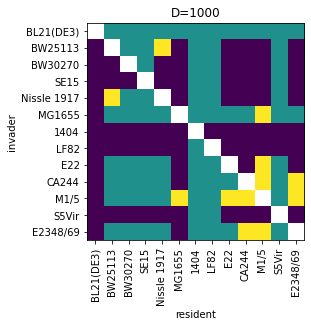

0
1
2
3
4
5
6
7
8
9
10
11
12


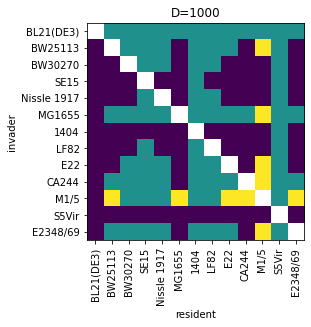

0
1
2
3
4
5
6
7
8
9
10
11
12


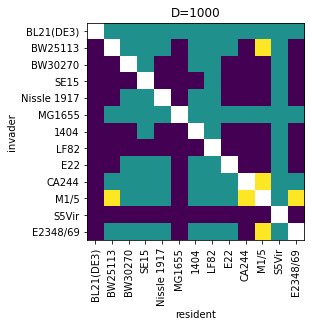

0
1
2
3
4
5
6
7
8
9
10
11
12


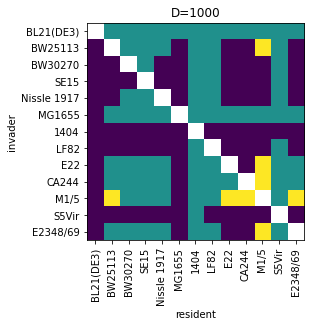

0
1
2
3
4
5
6
7
8
9
10
11
12


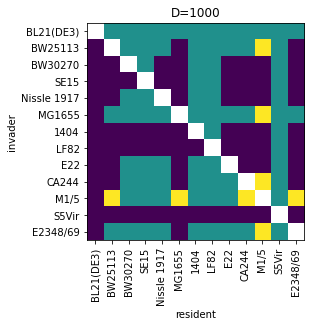

0
1
2
3
4
5
6
7
8
9
10
11
12


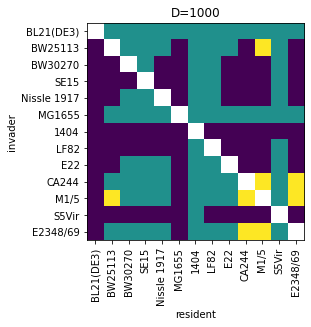

0
1
2
3
4
5
6
7
8
9
10
11
12


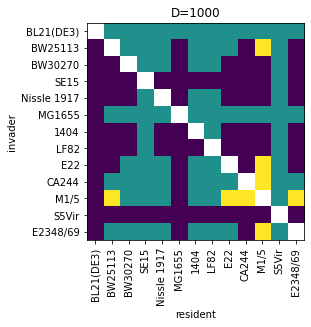

0
1
2
3
4
5
6
7
8
9
10
11
12


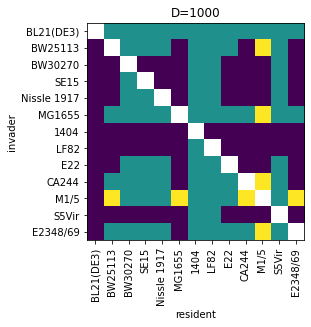

0
1
2
3
4
5
6
7
8
9
10
11
12


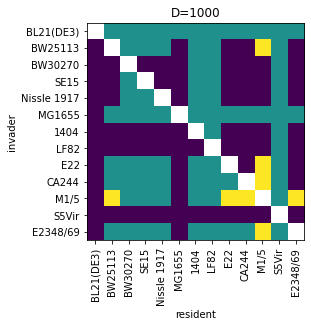

0
1
2
3
4
5
6
7
8
9
10
11
12


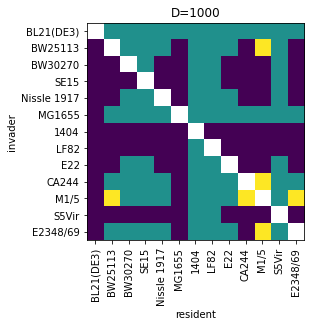

0
1
2
3
4
5
6
7
8
9
10
11
12


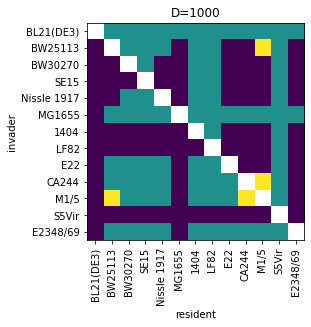

0
1
2
3
4
5
6
7
8
9
10
11
12


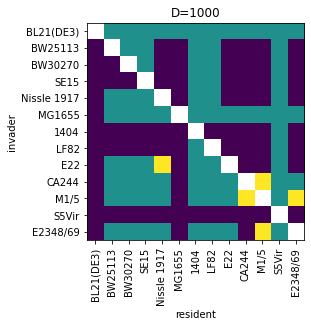

0
1
2
3
4
5
6
7
8
9
10
11
12


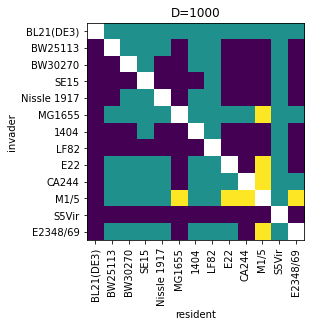

0
1
2
3
4
5
6
7
8
9
10
11
12


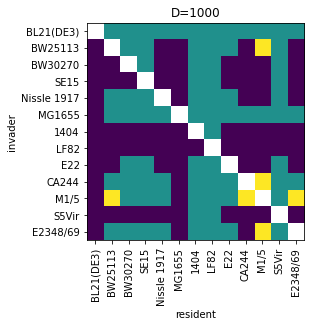

0
1
2
3
4
5
6
7
8
9
10
11
12


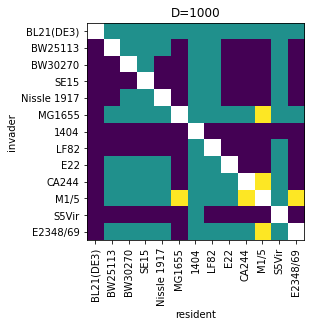

0
1
2
3
4
5
6
7
8
9
10
11
12


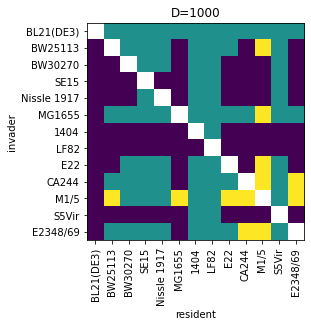

0
1
2
3
4
5
6
7
8
9
10
11
12


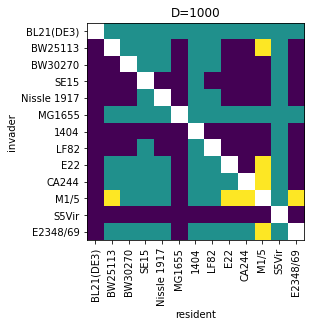

0
1
2
3
4
5
6
7
8
9
10
11
12


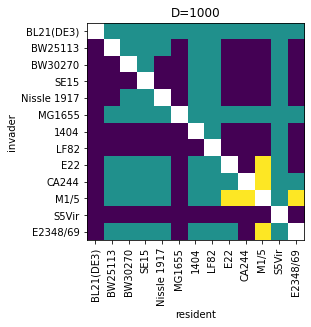

0
1
2
3
4
5
6
7
8
9
10
11
12


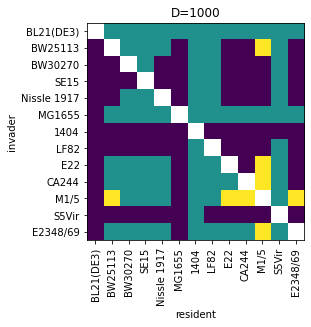

0
1
2
3
4
5
6
7
8
9
10
11
12


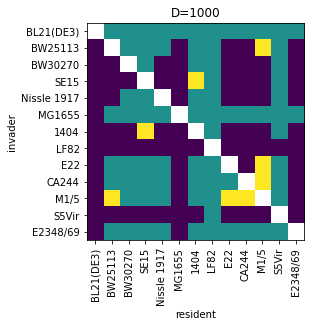

0
1
2
3
4
5
6
7
8
9
10
11
12


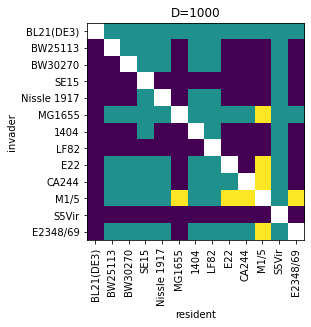

0
1
2
3
4
5
6
7
8
9
10
11
12


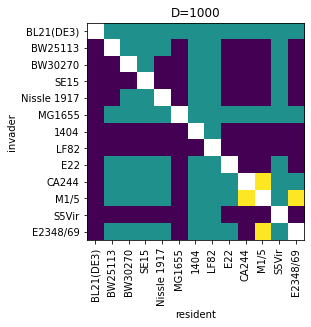

In [23]:
data=[]
for count in range(100):
    # with randomly chosen lags
    regrowth_lags = [(np.random.rand()+1)/2 for i in strains.columns]
    diauxic_lags = [np.random.rand() for i in strains.columns]
    results = []
    for i in range(13):
        results.append([])
        for j in range(13):
            results[-1].append(coex(strains.columns[i+1], strains.columns[j+1], 1/1000)[0])
        print(i)
    results = [[sum(j)+len(j)-1 for j in i] for i in results]
    # Replacement: 1
    # Coexistence: 2
    # uninvadable: 0
    for i in range(len(results)):
        results[i][i] = np.nan
    data.append([regrowth_lags, diauxic_lags, results])
    plt.imshow(np.array(results))
    ax = plt.gca();
    ax.set_xticks(range(13))
    ax.set_yticks(range(13))
    ax.set_xticklabels(strains.columns[1:14], rotation=90);
    ax.set_yticklabels(strains.columns[1:14]);
    plt.xlabel('resident')
    plt.ylabel('invader')
    plt.title('D=1000')
    plt.show()
    
# pickle.dump(data, open('random_coexistence.pkl', 'wb'))

In [4]:
data = pickle.load(open('random_coexistence.pkl', "rb" ))

In [33]:
excl=0
coex=0
bist=0
for datum in data:
    mat=datum[2]
    for i in range(13):
        for j in range(i):
            if(mat[i][j]+mat[j][i]==1):
                excl+=1
            elif(mat[i][j]+mat[j][i]==0):
                bist+=1
            elif(mat[i][j]+mat[j][i]==4):
                coex+=1
cases = [excl, coex, bist]
print("percentage of exclusion, coexistence, bistability", [i/sum(cases)*100 for i in cases])

percentage of exclusion, coexistence, bistability [95.23992814985887, 4.670259173723377, 0.08981267641775725]


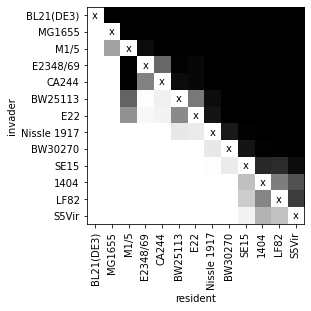

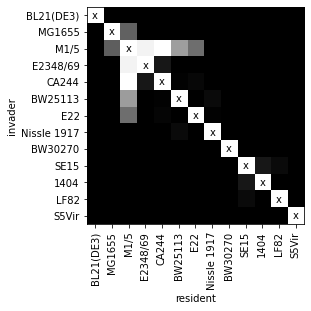

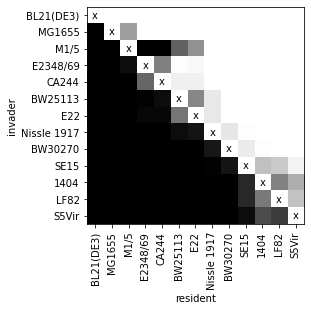

In [25]:
overall_imshow = []
for i in range(13):
    overall_imshow.append([])
    for j in range(13):
        samples = [data[idx][2][i][j] for idx in range(100)]
        overall_imshow[-1].append([samples.count(idx)/len(samples) for idx in range(3)])
overall_imshow=np.array(overall_imshow)

# uninvadable, replacement, coexistence, IN THAT ORDER
# But need to consider: row coordinate is resident in data but is invader in presentation. so need to 
# swap the uninv and rep. 

winscore = [sum([overall_imshow[i][j][0] for j in range(13)]) for i in range(13)]
order = list(range(13))
order.sort(key=lambda x: winscore[x], reverse = False)
new_overall = overall_imshow.copy().tolist()
uninv = overall_imshow.copy().tolist()
rep = overall_imshow.copy().tolist()
alphas = np.zeros([13, 13]).tolist()
for i in range(13):
    for j in range(13):
        new_overall[i][j] = overall_imshow[order[i]][order[j]]
        alphas[i][j] = new_overall[i][j][2]
        uninv[i][j] = new_overall[i][j][1]
        rep[i][j] = new_overall[i][j][0]
    uninv[i][i] = np.nan
    rep[i][i] = np.nan
    alphas[i][i] = np.nan

# make some colorbar
from matplotlib import cm
from matplotlib.colors import ListedColormap
newcolors = np.array([np.array([171, 55, 200, i])/255 for i in range(255)])
purples = ListedColormap(newcolors)

grid=np.array(rep)
plt.imshow(grid, cmap='gray')
ax = plt.gca()
ax.set_xticks(range(13))
ax.set_yticks(range(13))
ax.set_xticklabels([strains.columns[1:14][i] for i in order], rotation=90);
ax.set_yticklabels([strains.columns[1:14][i] for i in order]);
ax.set_xlabel('resident')
ax.set_ylabel('invader')
# cbar = fig.colorbar(shows, ax=ax, shrink=0.7)
for (j,i),label in np.ndenumerate(grid):
    if(i==j):ax.text(i,i,'x',ha='center',va='center')
plt.savefig('avr0.pdf', bbox_inches="tight")
plt.show()

bx = plt.gca()
plt.imshow(alphas, cmap='gray')
bx.set_xticks(range(13))
bx.set_yticks(range(13))
bx.set_xticklabels([strains.columns[1:14][i] for i in order], rotation=90);
bx.set_yticklabels([strains.columns[1:14][i] for i in order]);
bx.set_xlabel('resident')
bx.set_ylabel('invader')
# add text
for (j,i),label in np.ndenumerate(alphas):
    if(i==j):bx.text(i,i,'x',ha='center',va='center')
plt.savefig('avr1.pdf', bbox_inches="tight")
plt.show()

cx = plt.gca()
grid=np.array(uninv)
plt.imshow(grid, cmap='gray')
cx.set_xticks(range(13))
cx.set_yticks(range(13))
cx.set_xticklabels([strains.columns[1:14][i] for i in order], rotation=90);
cx.set_yticklabels([strains.columns[1:14][i] for i in order]);
cx.set_xlabel('resident')
cx.set_ylabel('invader')
# add text
for (j,i),label in np.ndenumerate(grid):
    if(i==j):cx.text(i,i,'x',ha='center',va='center')
# cbar = fig.colorbar(shows, ax=cx, shrink=0.7)
plt.savefig('avr2.pdf', bbox_inches="tight")
plt.show()

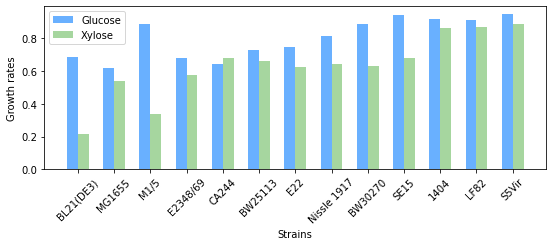

In [59]:
plt.figure(figsize=[9, 3])
colors=['#067cffff', '#a6d69fff']

gglu = [strains.iloc[0, 1:14][i] for i in order]
gxyl = [strains.iloc[1, 1:14][i] for i in order]
X = np.arange(len(gglu))
# Passing the parameters to the bar function, this is the main function which creates the bar plot
# Using X now to align the bars side by side
plt.bar(X, gglu, color = colors[0], alpha=0.6, width = 0.3)
plt.bar(X + 0.3, gxyl, color = colors[1], alpha=1, width = 0.3)
# Creating the legend of the bars in the plot
plt.legend(['Glucose', 'Xylose'])
# Overiding the x axis with the country names
plt.xticks([i + 0.15 for i in range(len(gglu))], order, rotation=45)
# Namimg the x and y axis
plt.xlabel('Strains')
plt.ylabel('Growth rates')
# Saving the plot as a 'png'
plt.savefig('growth.pdf', bbox_inches="tight")
# Displaying the bar plot
plt.show()

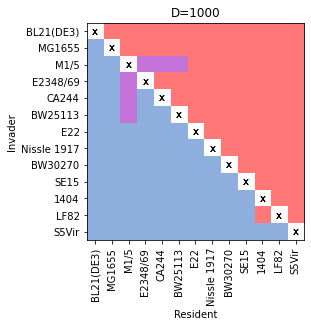

In [17]:
overall_imshow = []
for i in range(13):
    overall_imshow.append([])
    for j in range(13):
        samples = [data[idx][2][i][j] for idx in range(1)]
        overall_imshow[-1].append([samples.count(idx)/len(samples) for idx in range(3)])
overall_imshow=np.array(overall_imshow)
winscore = [sum([overall_imshow[i][j][0] for j in range(13)]) for i in range(13)]

overall_imshow=[]
def polishImshow(mat, order):
    global overall_imshow
    overall_imshow = []
    for i in range(13):
        overall_imshow.append([])
        for j in range(13):
            samples = [mat[i][j]]
            overall_imshow[-1].append([samples.count(idx)/len(samples) for idx in range(3)])
    overall_imshow=np.array(overall_imshow)
    # for i in range(13):
    #     for j in range(i+1):
    #         overall_imshow[j][i]=[1, 1, 1]
    new_overall = overall_imshow.copy()
    for i in range(13):
        for j in range(13):
            new_overall[j][i] = np.array([[255, 94, 171], [60, 139, 55], [60, 209, 200]]) @ overall_imshow[order[i]][order[j]]
        new_overall[i][i] = 255
    new_overall/=255
#     print(new_overall)
    plt.imshow(new_overall, alpha=0.7)
    ax = plt.gca();
    ax.set_xticks(range(13))
    ax.set_yticks(range(13))
    ax.set_xticklabels([strains.columns[1:14][i] for i in order], rotation=90);
    ax.set_yticklabels([strains.columns[1:14][i] for i in order]);
    plt.xlabel('Resident')
    plt.ylabel('Invader')
    plt.title('D=1000')
    for (j,i,k),label in np.ndenumerate(new_overall):
        if(i==j):ax.text(i,i,'x',ha='center',va='center')
    
order = list(range(13))
order.sort(key=lambda x: winscore[x], reverse = False)
# polishImshow(data[53][2], order)
polishImshow(data[0][2], order)
# plt.savefig('example3.pdf', bbox_inches="tight")